In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend
%matplotlib inline

In [4]:
from load_dataset import Dataset

In [5]:
dataset = Dataset('../data/dataset/')

In [6]:
# dow_jones_0
ts = dataset["dow_jones_0.csv"]

In [7]:
len(ts)

250

In [8]:
ts, ts_test = ts[:220], ts[220:]

<AxesSubplot:xlabel='2018-11-30'>

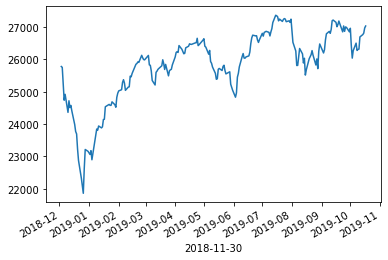

In [9]:
ts.plot()

<AxesSubplot:xlabel='2018-11-30'>

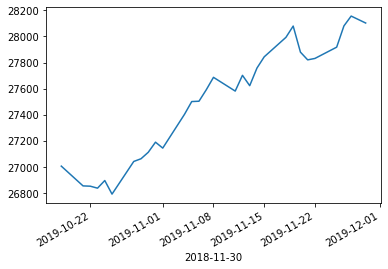

In [10]:
ts_test.plot()

## Box-Jenkins

In [11]:
# Теперь подберем порядки дифференцирования d, D
# d малое подбирается таким образом, что d раз продифференцировав ряд, мы добьемся стационарности
# обычно таким дифференцированием убирают тренды
# D большое обычно подбирается так, что если d малое не дало стацинарности, мы можем D раз сезонно придифференцировать
# ряд, пока он не станет стационарным.

In [12]:
# для начала просто продифференцируем один раз

<AxesSubplot:xlabel='2018-11-30'>

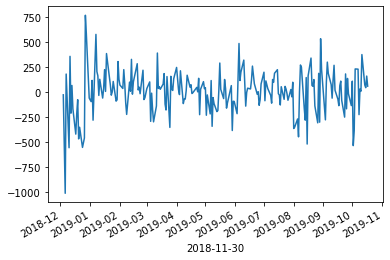

In [13]:
ts.diff().plot()

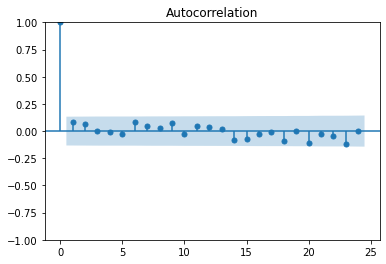

In [14]:
# в данном случае сезонности нет
plot_acf(ts.diff().dropna());

In [15]:
#критерий Дики Фуллера
# видим, что можно отвергнуть нулевую гипотезу
adfuller(ts.diff().dropna())[1]

3.122199071564044e-25

In [16]:
# отлично, вердикт о стационарности подтвержден, (d, D) = (1, 0)

In [17]:
# теперь разберемся с параметрами q, Q, p, P.

In [18]:
ts_flat = ts.diff().dropna()

<AxesSubplot:xlabel='2018-11-30'>

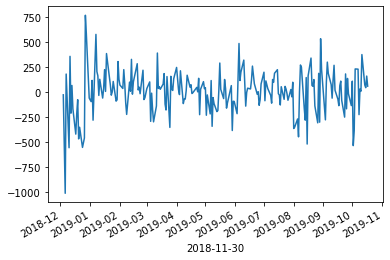

In [19]:
ts_flat.plot()

/Users/a18387289/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


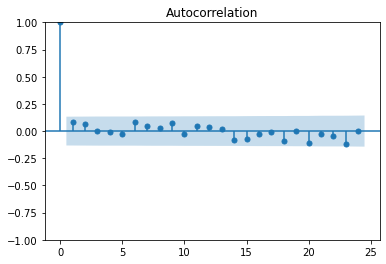

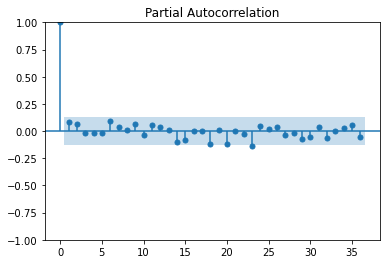

In [22]:
# для поиска параметров q, Q, p, P нарисуем график автокорреляции и частичной автокорреляции
# на графиках мы видим что резкое падение частичной автокорреляции, и плавное затухание полной автокорреляции,
# следовательно, наш ряд может быть описан моделью (p, d, 0), (P, D, 0). Итак, q = 0, Q = 0.
plot_acf(ts_flat);
plot_pacf(ts_flat, lags=36);

/Users/a18387289/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


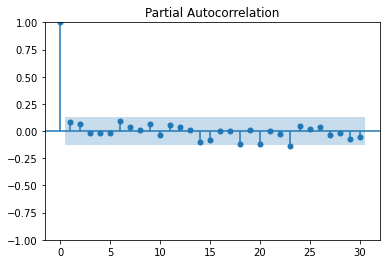

In [23]:
# найдем теперь параметры p, P
# p малое определяется как последний несезонный лаг, находящийся выше доверительного интервала
# в данном случае это p = 0, аналогично с сезонными лагами мы не видим никаких сезонных всплесков, 
# значит P = 0, итак (p, P) = (0, 0)
plot_pacf(ts_flat, lags=30);

In [21]:
# теперь попробуем построить SARIMA с этими параметрами

In [26]:
from statsmodels.tsa.statespace import sarimax

In [24]:
pdq = (0, 1, 0)
PDQ = (0, 0, 0, 0)

In [27]:
model = sarimax.SARIMAX(ts, order=pdq, seasonal_order=PDQ)

/Users/a18387289/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a18387289/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [28]:
res = model.fit()

In [29]:
preds = res.forecast(30)

/Users/a18387289/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [30]:
preds.index = ts_test.index

In [31]:
plotting.plot_ts(ts, preds, ts_test)

Loading BokehJS ...

In [32]:
# Видим что получилось плохо!

In [33]:
from sklearn.metrics import mean_squared_error as mse

mse(preds, ts_test)

403722.5488308233

## Auto arima

In [34]:
# наиболее удобная реализация AutoArima находится в модуле pmdarima
from pmdarima import auto_arima

In [42]:
# на вход подается ряд со всеми преобразованиями кроме дифференцирования, границы поиска параметров p, q, P, Q, 
# периодом сезонности m, параметрами дифференцирования d, D
model = auto_arima(
     ts, start_p=0, start_q=0,
     max_p=3, max_q=3, m=0,
     start_P=0, start_Q=0, seasonal=False,
     d=1, D=0, trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2985.126, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2985.836, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2985.702, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2983.276, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.240 seconds


In [152]:
# в результате работы возвращается обьект ARIMA
model

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(2, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [43]:
# прогноз можем получить методом predict, указав горизонт прогнозирования
preds = model.predict(len(ts_test))

In [44]:
plotting.plot_ts(ts, ts_test, pd.Series(preds, index=ts_test.index))

Loading BokehJS ...

Вывод: модель крайне плохо справилась с прогнозированием индекса. Видимо модель смогла лишь распознать слабый тренд